### An example of how to manipulate the dateframes

In [6]:
import sys,os,os.path

# tell python to look for the path to analyse
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import pandas as pd
import h5py

from core import processing as proc
from core import plotting as pl
from core import misc as misc
from core import fitting as fit

Currently you have:
- pmtrw: the raw pmt waveforms
- subwf: the pmt waveforms with baseline subtraction
- summary: the pandas dataframe containing:
    -    integration values (ADC)
    -    sigma values across the waveform peak
    -    height of the waveform peak

#### To access each separate section, do so as described below:

Read in the data

In [7]:
path = "../../storage/John/testing/RUN000082/PMT/Nominal/wave_6.h5"
#df = pd.read_hdf(path, key = 'pmtrw')
f = h5py.File(path)
print(list(f.keys()))


['pmtrw', 'subwf', 'summary']


### ACCESSING WAVEFORMS

Simply collect them element-wise as described below

Waveform values:
[8183 8181 8189 ... 8183 8183 8187]


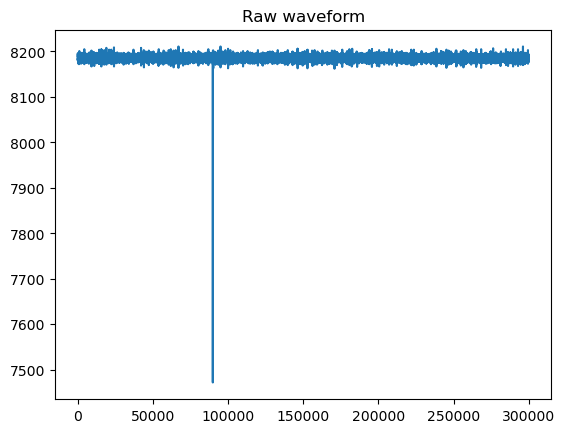

In [27]:
# take first waveform
wf_1 = f['pmtrw'][0]
print("Waveform values:")
print(wf_1)

# visualising it
length = len(wf_1)

time = np.linspace(0,length*2, num = length)
plt.plot(time, wf_1)
plt.title("Raw waveform")
plt.show()

Same rules apply for the subtracted waveforms

Waveform values:
[ 2.  4. -4. ...  2.  2. -2.]


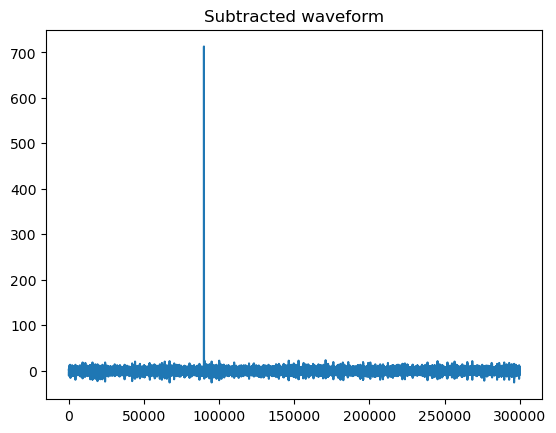

In [9]:
# take first waveform
wf_1 = f['subwf'][0]
print("Waveform values:")
print(wf_1)

# visualising it
length = len(wf_1)

time = np.linspace(0,length*2, num = length)
plt.plot(time, wf_1)
plt.title("Subtracted waveform")
plt.show()

### ACCESSING THE SUMMARY TABLE

This requires using the function `read_hdf` to interpret the information from the summary table. This only works because I spend hours trying to find a nice way to format it within the h5 file and gave up.

,ADC,sigma,heights
0,1984.0,3.175300,713.0
1,1806.0,2.136453,755.0
2,1902.0,2.751424,861.0
3,3116.0,2.898002,1125.0
4,1769.0,4.776938,662.0
...,...,...,...
4838,9414.0,3.122301,3115.0
4839,2164.0,3.436723,677.0
4840,1497.0,3.710016,535.0
4841,1956.0,3.170270,790.0


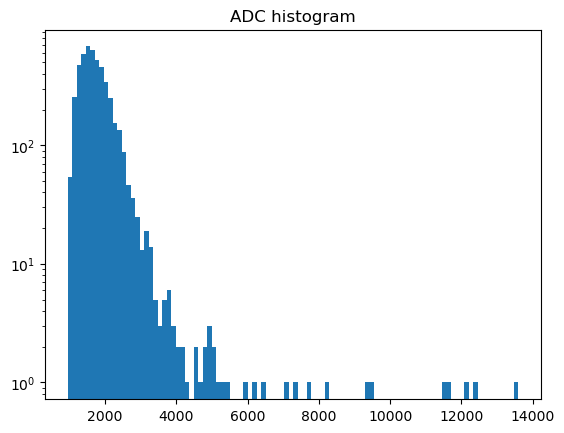

In [10]:
df = pd.read_hdf(path)
display(df)

plt.hist(df.ADC.to_numpy(), bins = 100)
plt.yscale('log')
#plt.xlim([-100,1000])
plt.title("ADC histogram")
plt.show()

This now allows for basic data manipulation, as shown:

In [11]:
df['sigma'] = df['sigma'].fillna(0)

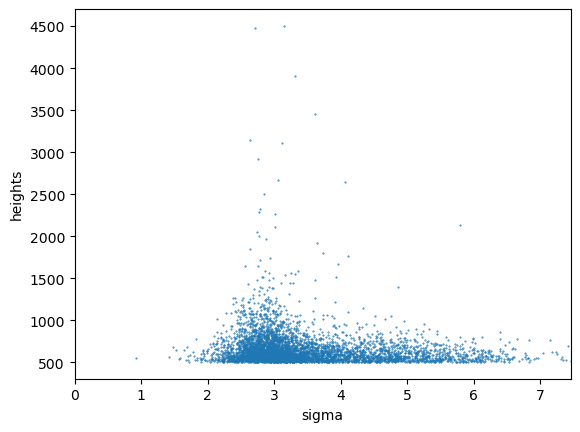

In [16]:
plt.scatter(df['sigma'], df['heights'], s = 0.2)
plt.xlabel('sigma')
plt.ylabel('heights')
plt.xlim([0, df.sigma.max()])
plt.show()

In [10]:
# apply mask to the dataframe to collect sigma = 0 events with highest height first 
df_zeros = df[df['sigma'] == 0]
display(df_zeros.sort_values('heights'))

,ADC,sigma,heights


In [17]:
def print_wf(number = 1):
    
    wf_1 = f['subwf'][number]
    print("Waveform values:")
    print(wf_1)

    # visualising it
    length = len(wf_1)

    time = np.linspace(0,length*2, num = length)
    plt.plot(time*10**-3, wf_1)
    plt.title("Event {}".format(number))
    plt.xlabel("Time (us)")
    plt.show()

Waveform values:
[-1.  6. -3. ...  1. -6.  4.]


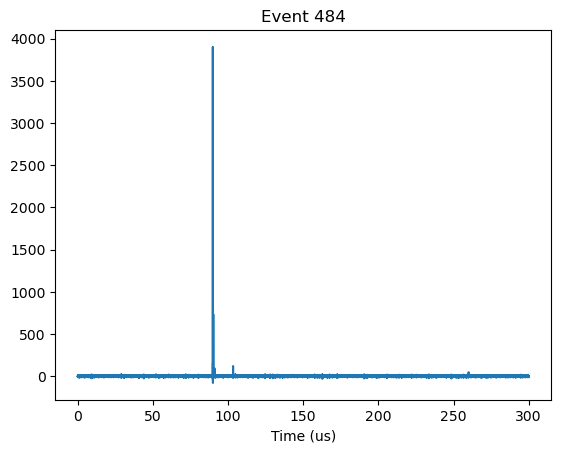

In [24]:
print_wf(484)

lets look at the largest event

In [20]:
df.sort_values('heights')

,ADC,sigma,heights
4665,1349.0,2.918612,506.0
4366,1277.0,4.357188,506.0
1283,2171.0,4.097482,506.0
1534,1825.0,5.002233,506.0
3584,1766.0,5.478194,506.0
...,...,...,...
3225,8225.0,2.634458,3148.0
2176,11553.0,3.607743,3457.0
484,11593.0,3.314696,3903.0
2306,13599.0,2.705782,4472.0


Waveform values:
[-1.  6. -3. ...  1. -6.  4.]


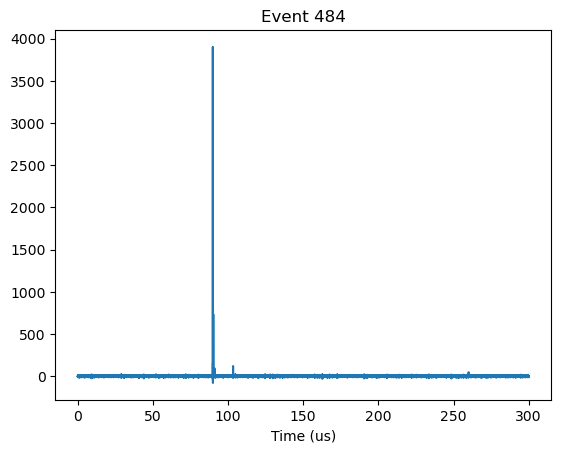

In [25]:
print_wf(484)

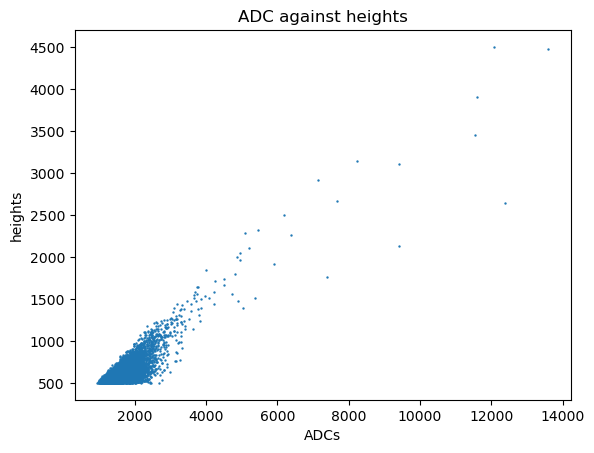

In [21]:
plt.scatter(df.ADC.to_numpy(), df.heights.to_numpy(), s = 0.5)
plt.title("ADC against heights")
plt.xlabel('ADCs')
plt.ylabel('heights')
plt.show()

there are some NaN sigmas in here, lets look at those events

In [29]:
df[df.sigma < -1]

,ADC,sigma,heights
3547,1268.0,-9999.0,585.0
4451,994.0,-9999.0,516.0


Waveform values:
[ 1.  4. -6. ...  5.  1. -6.]


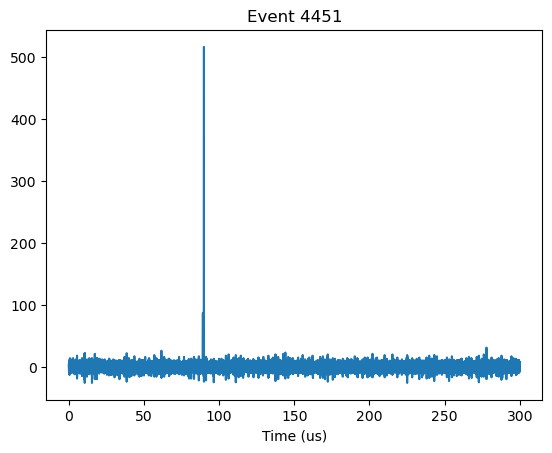

Waveform values:
[ 0. -1. -1. ...  5. -2. -4.]


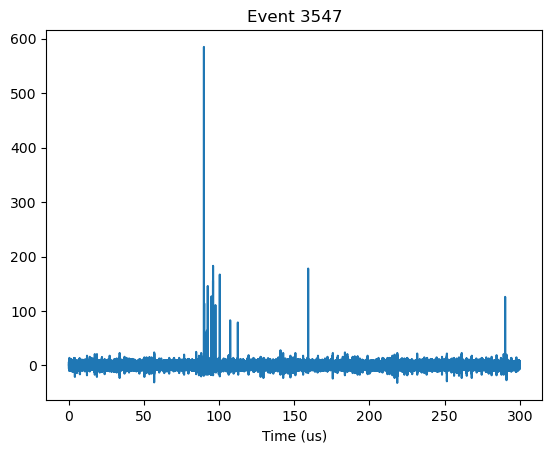

In [31]:
print_wf(4451)
print_wf(3547)